In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor

# 1. Đọc file dữ liệu

In [2]:
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")

outlier_columns = list(df.columns[:6])

outlier_columns

['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

# 2. Biểu diễn dữ liệu ngoại lai

## 2.1. Biểu diễn bằng biểu đồ hộp

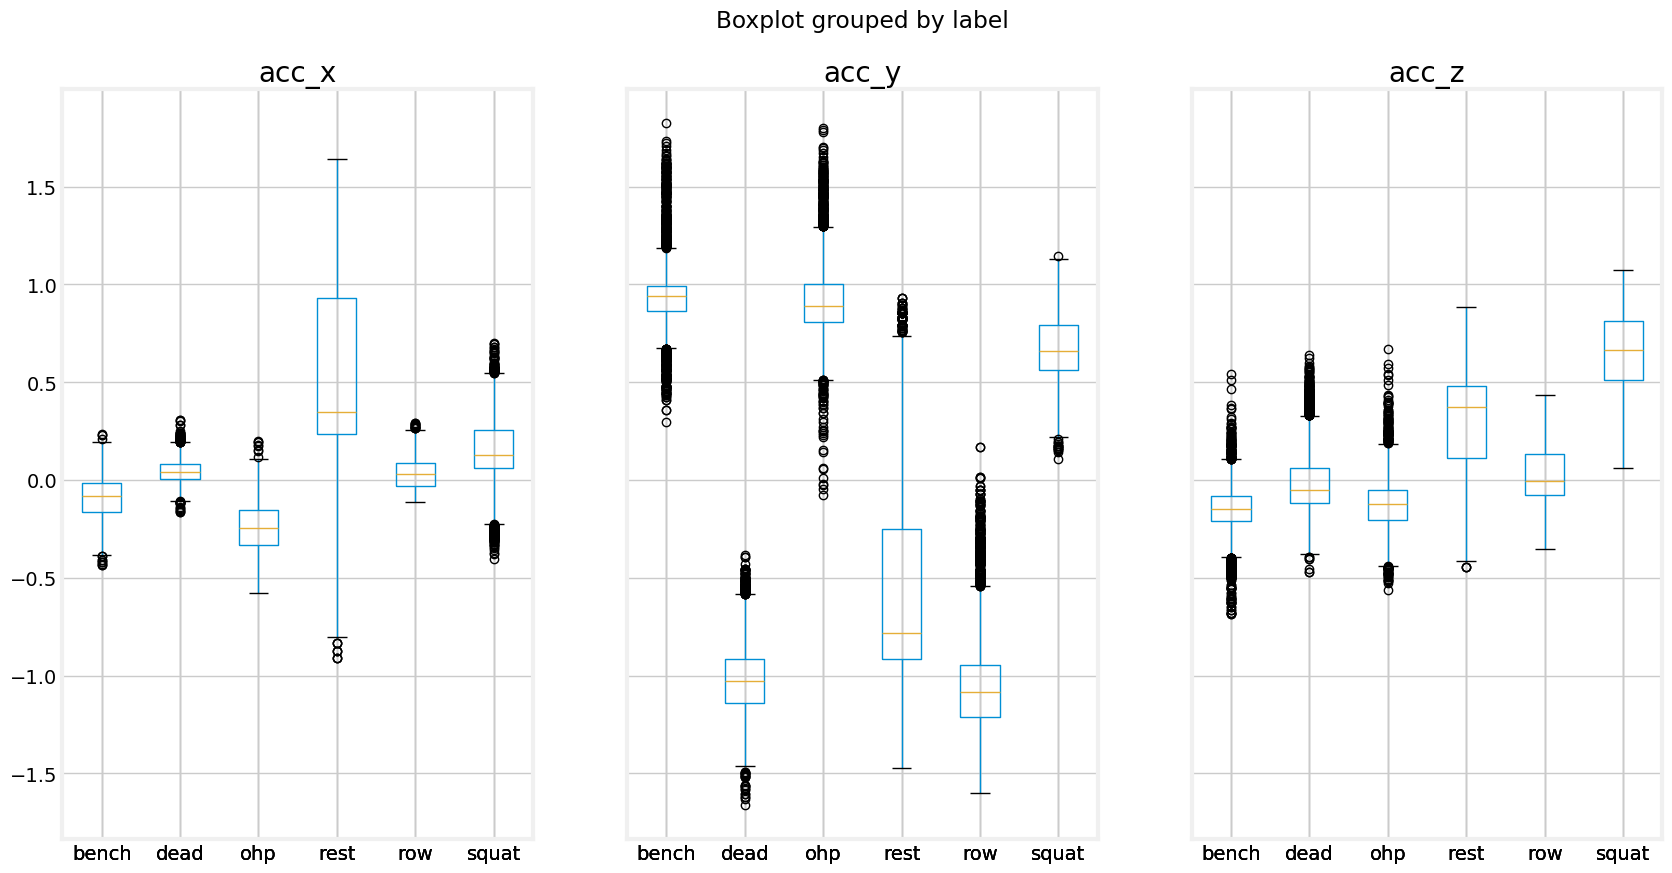

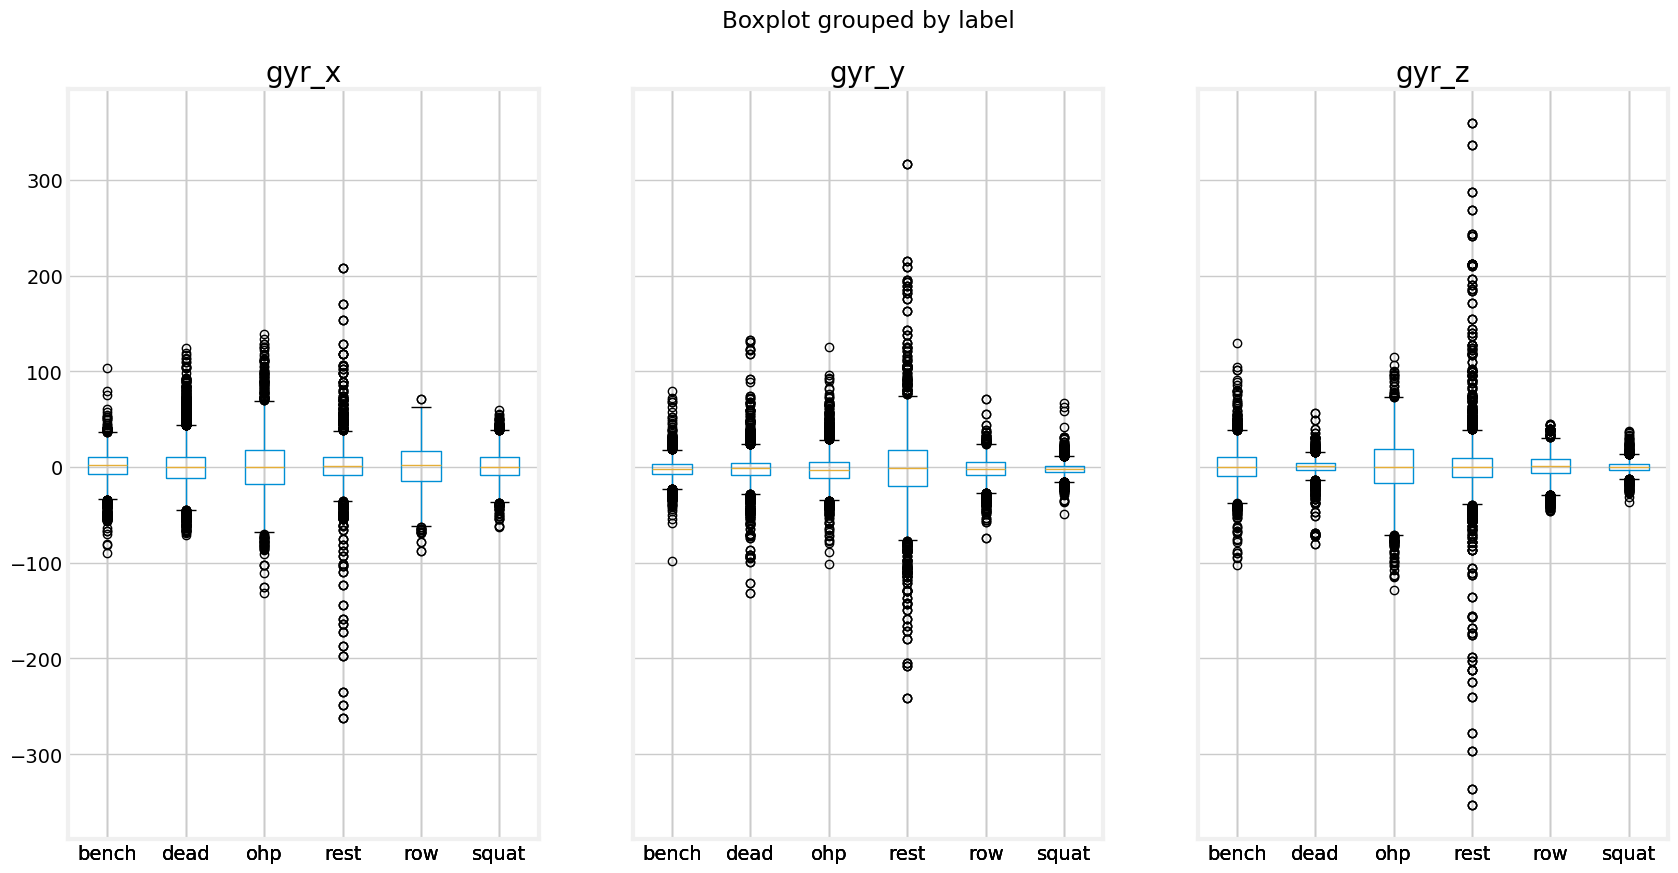

In [39]:
# Use the desired style and set figure parameters
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.facecolor"] = 'white'  
plt.rcParams["figure.facecolor"] = 'white'

# First set of boxplots
ax1 = df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))

# Remove x-axis labels for the first set of plots
for ax in ax1.flatten():
    ax.set_xlabel('')

# Second set of boxplots
ax2 = df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))

# Remove x-axis labels for the second set of plots
for ax in ax2.flatten():
    ax.set_xlabel('')

plt.show()

In [3]:
# Hàm biểu diễn dữ liệu ngoại lai
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("Number of samples")
    plt.ylabel("Value")
    plt.rcParams["figure.facecolor"] = 'white'

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["inlier " + col, "outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

# 3. Loại bỏ dữ liệu ngoại lai

## 3.1. IQR

In [51]:
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

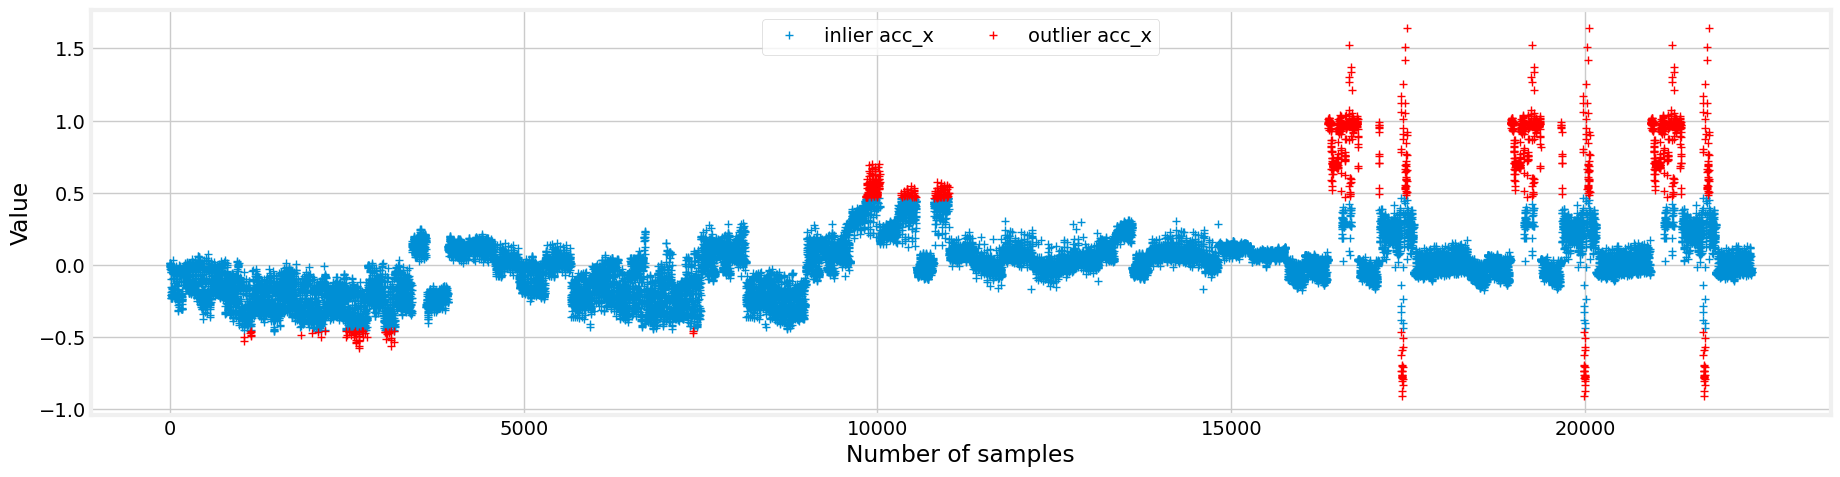

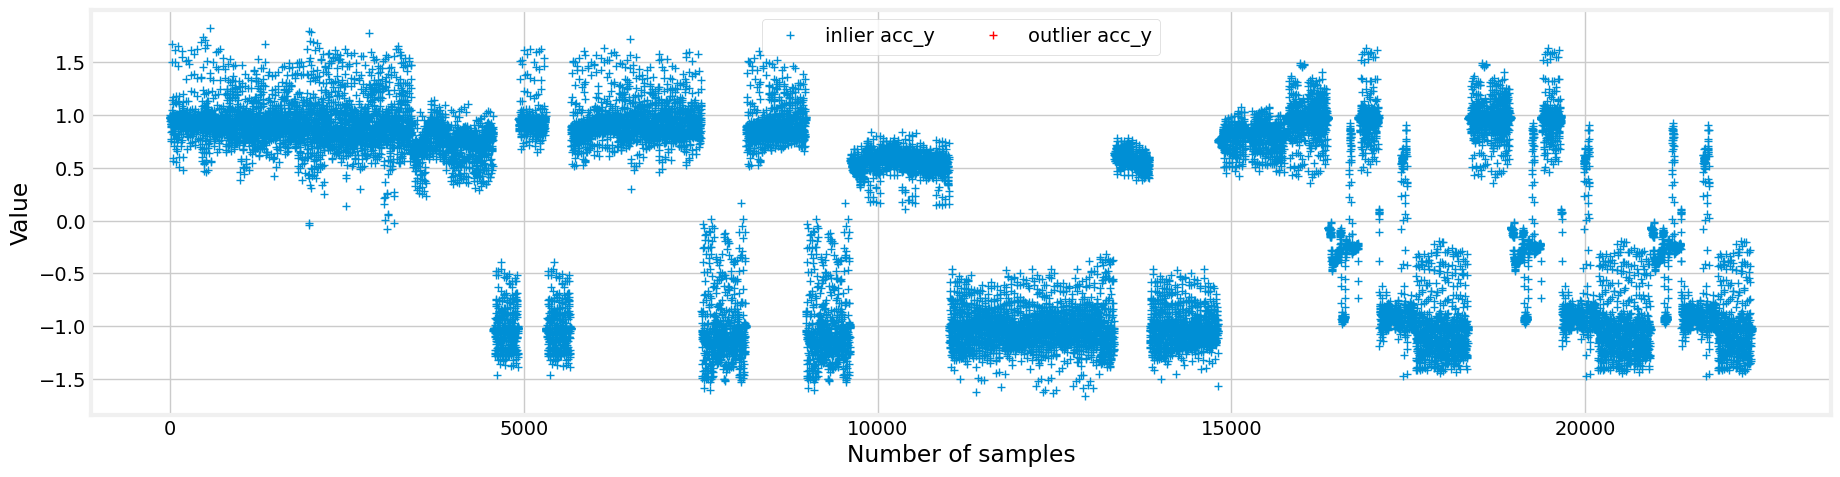

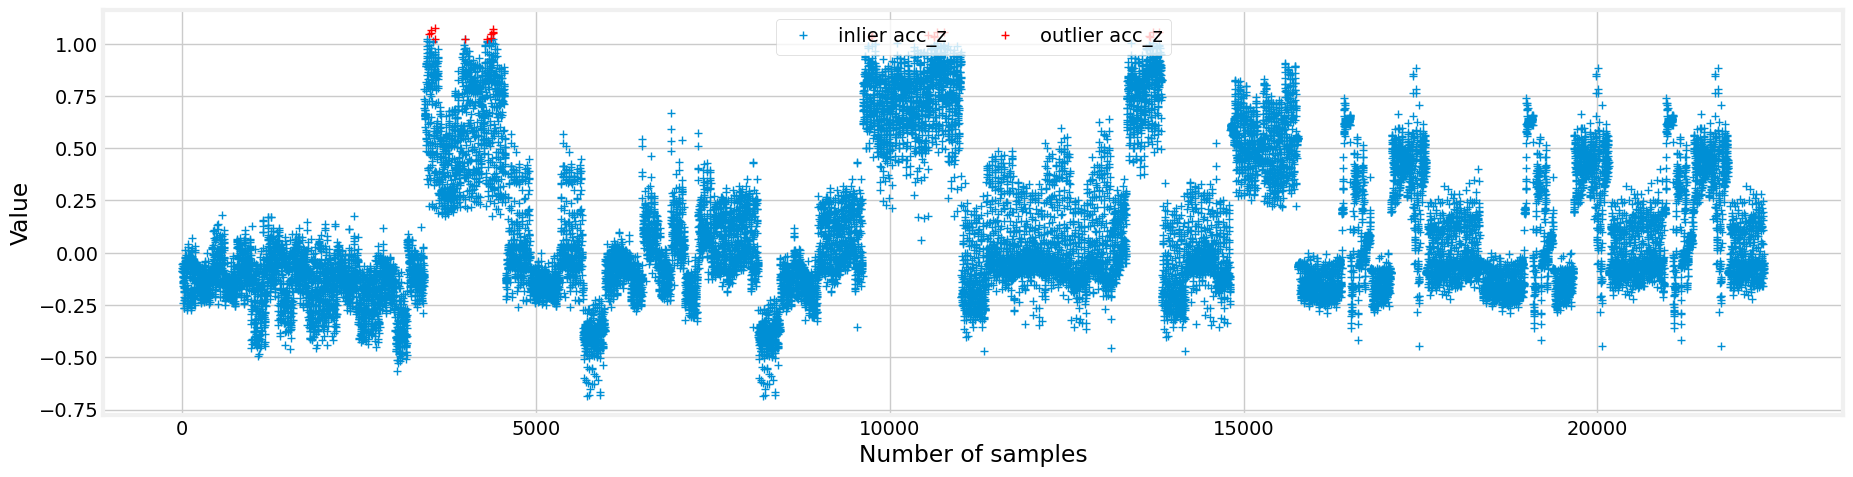

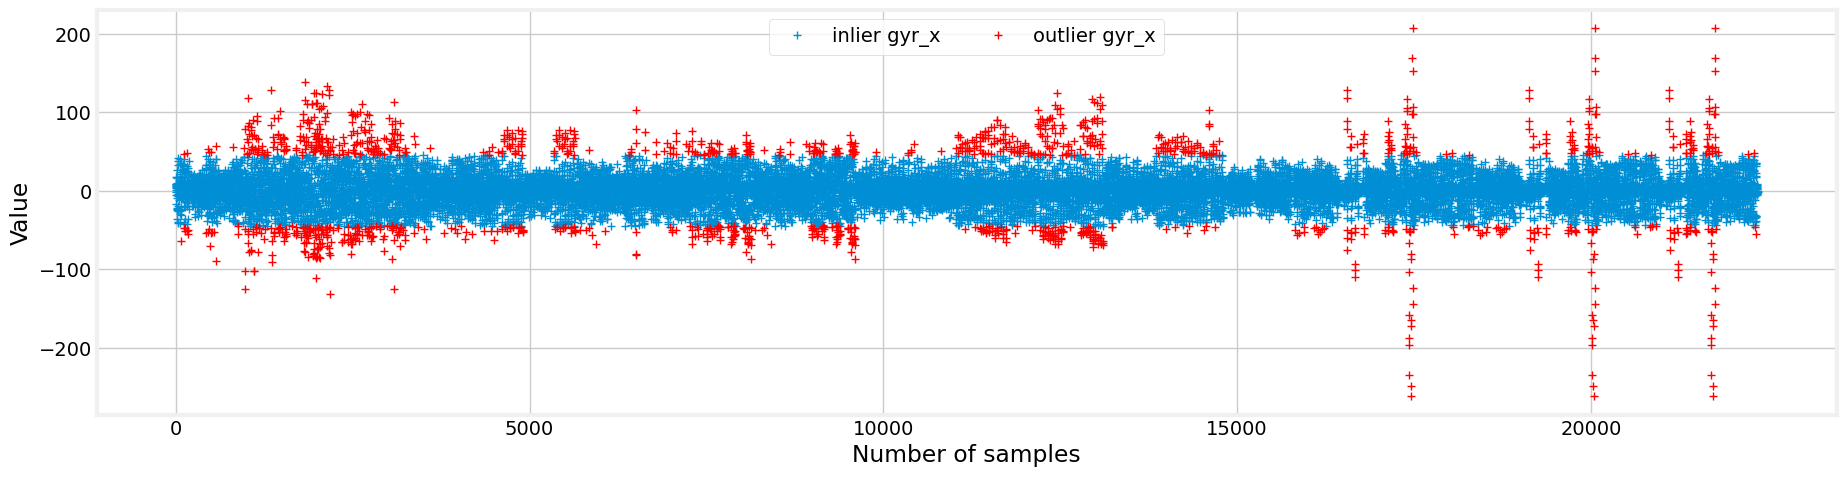

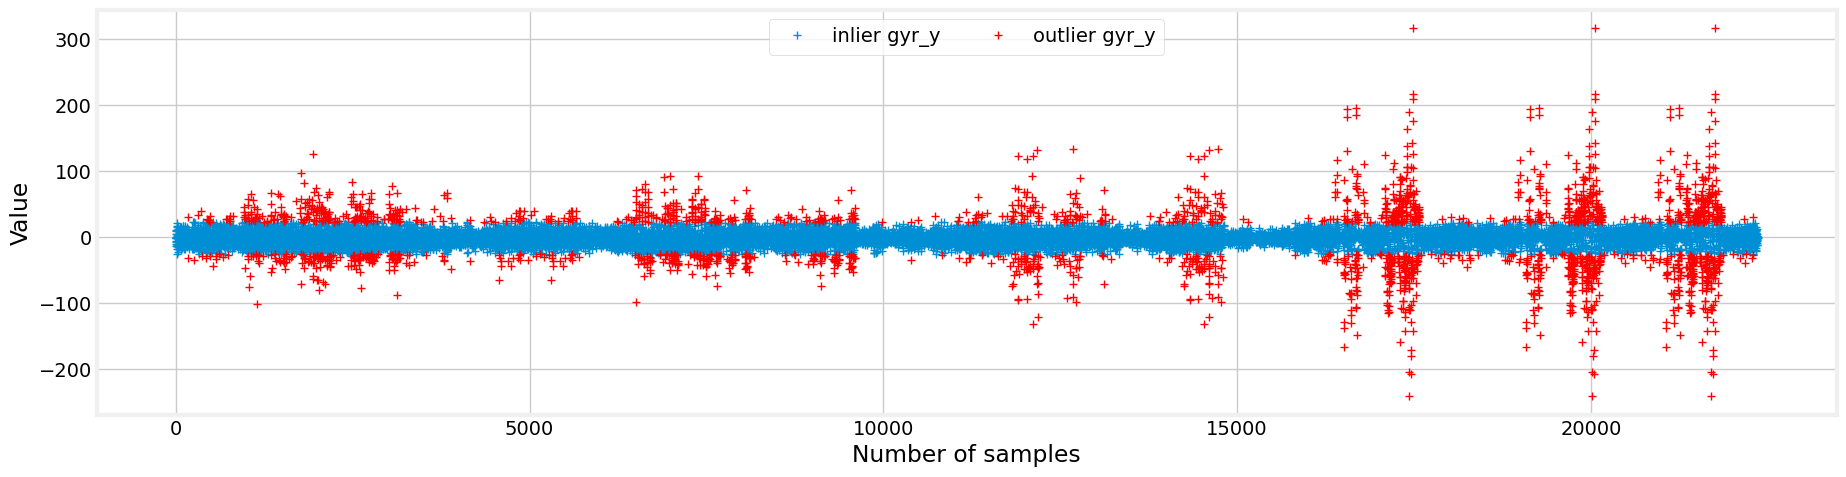

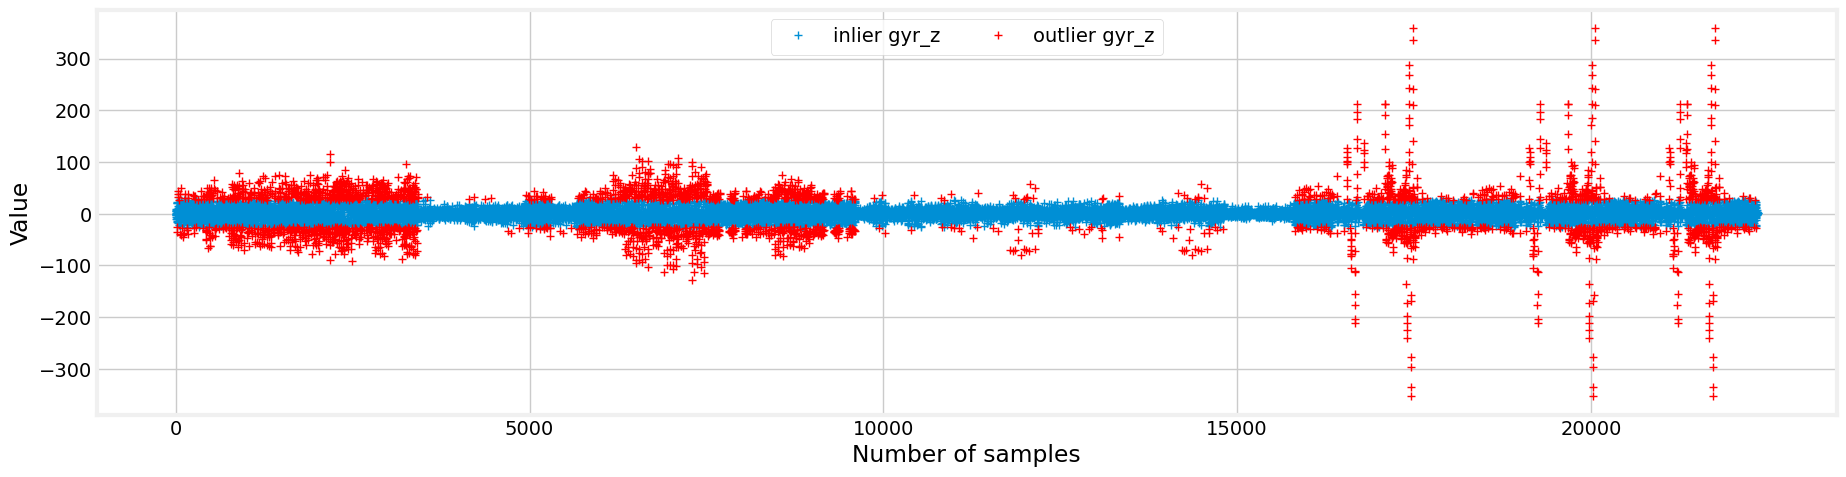

In [49]:
for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

## 3.2. Tiêu chuẩn Chauvenet

### 3.2.1. Kiểm tra phân phối chuẩn

array([[<AxesSubplot: title={'center': 'bench'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'dead'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<AxesSubplot: title={'center': 'rest'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'row'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'squat'}, ylabel='Frequency'>],
       [<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>]], dtype=object)

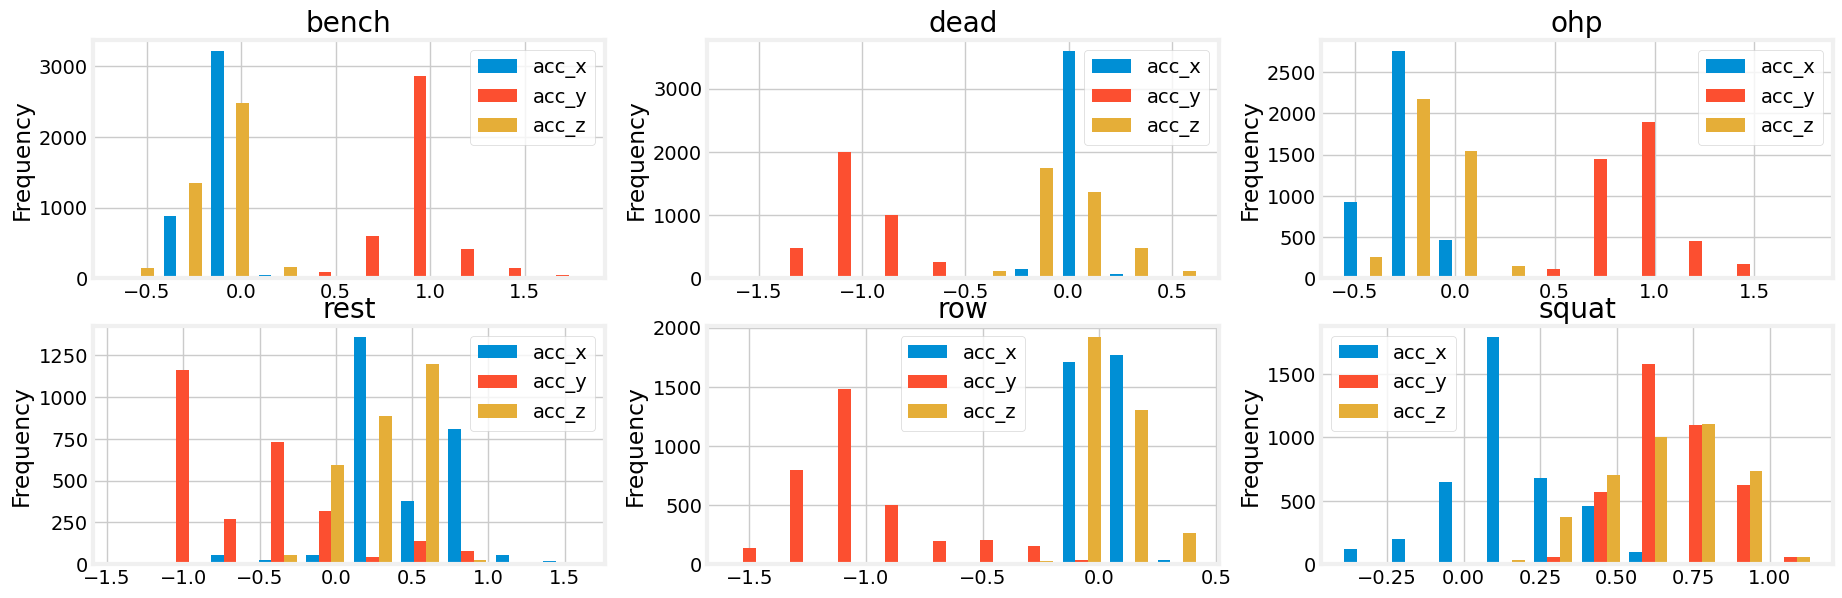

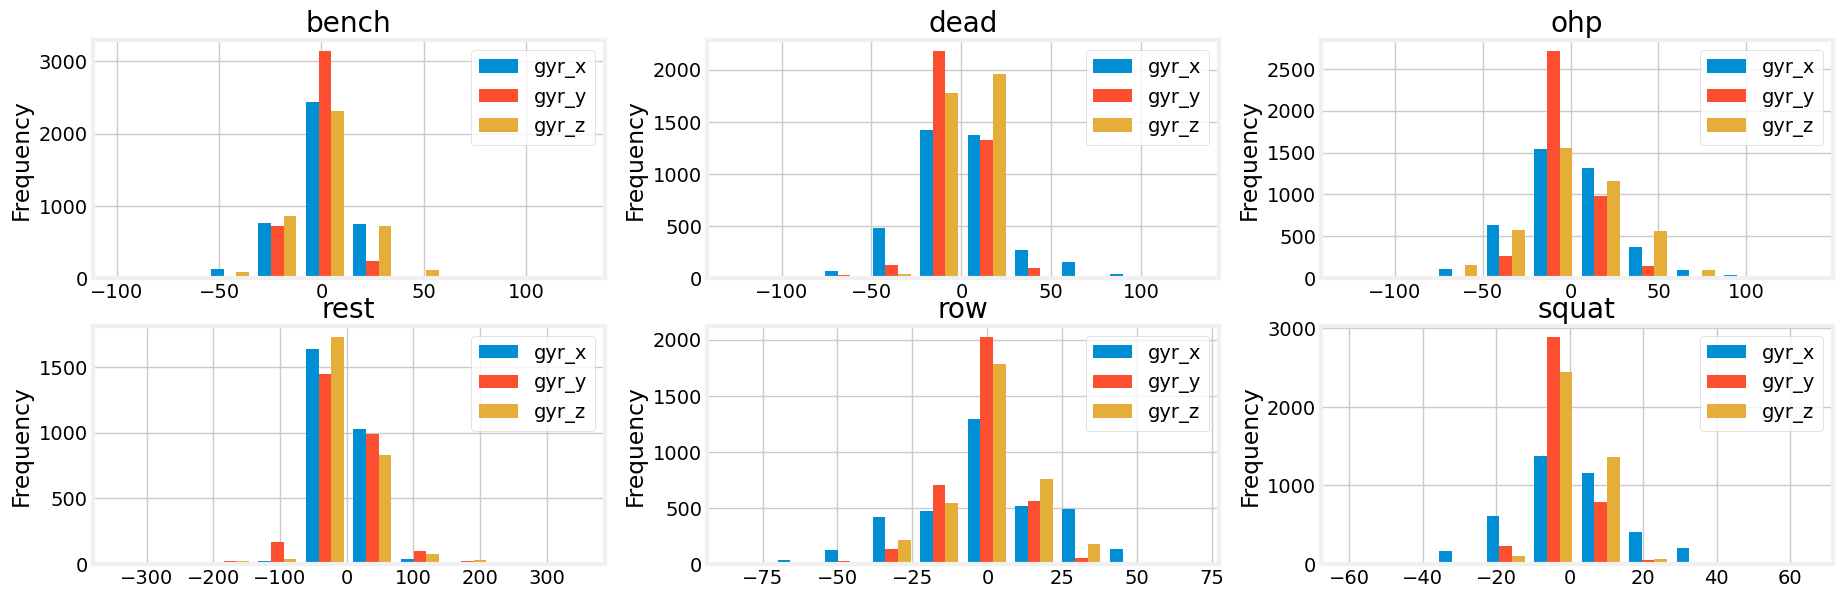

In [41]:
df[outlier_columns[:3] + ["label"]].plot.hist(
    by="label", figsize=(20, 10), layout=(3, 3)
)

df[outlier_columns[3:] + ["label"]].plot.hist(
    by="label", figsize=(20, 10), layout=(3, 3)
)

### 3.2.2. Loại bỏ dữ liệu ngoại lai

In [5]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.


    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(2)
    high = deviation / math.sqrt(2)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0
            - 0.5 * (scipy.special.erf(high.iloc[i]) - scipy.special.erf(low.iloc[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

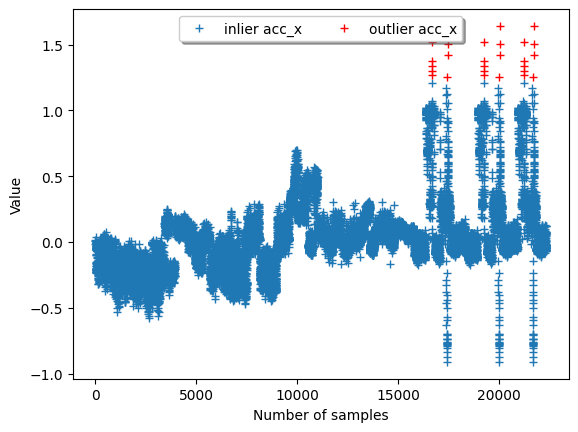

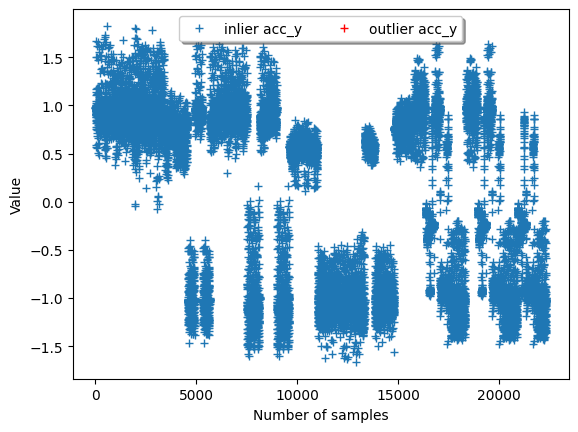

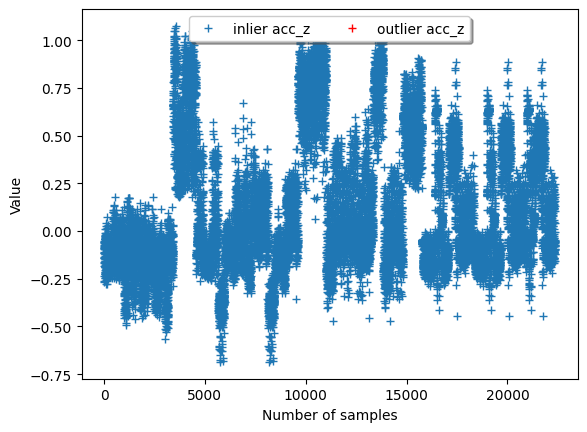

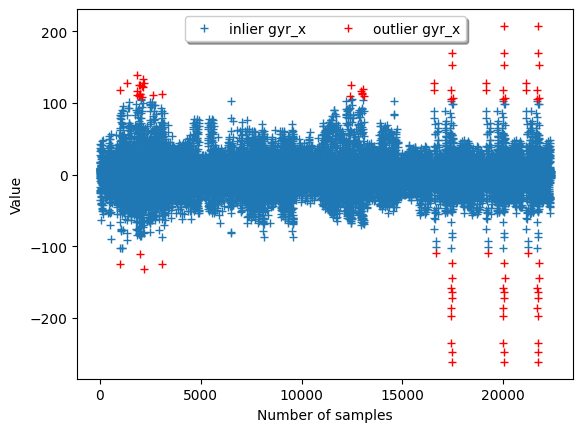

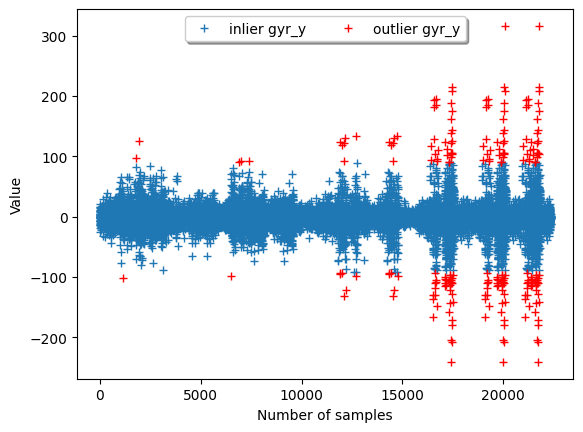

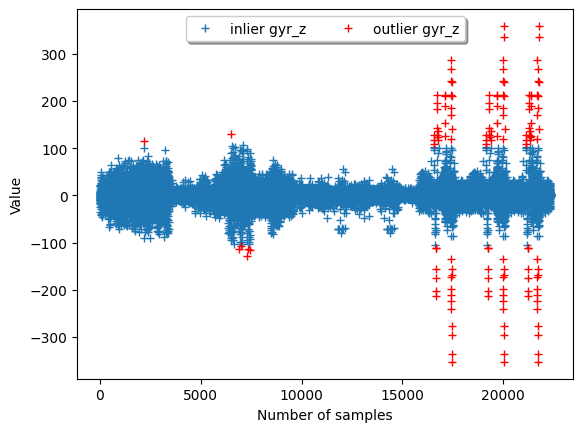

In [8]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

## 3.3. LOF

In [45]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()
    dataset["gyr_x"].mean()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

[-0.98763316 -1.12931697 -1.03650219 ... -0.96968897 -1.0117304
 -0.96330522]


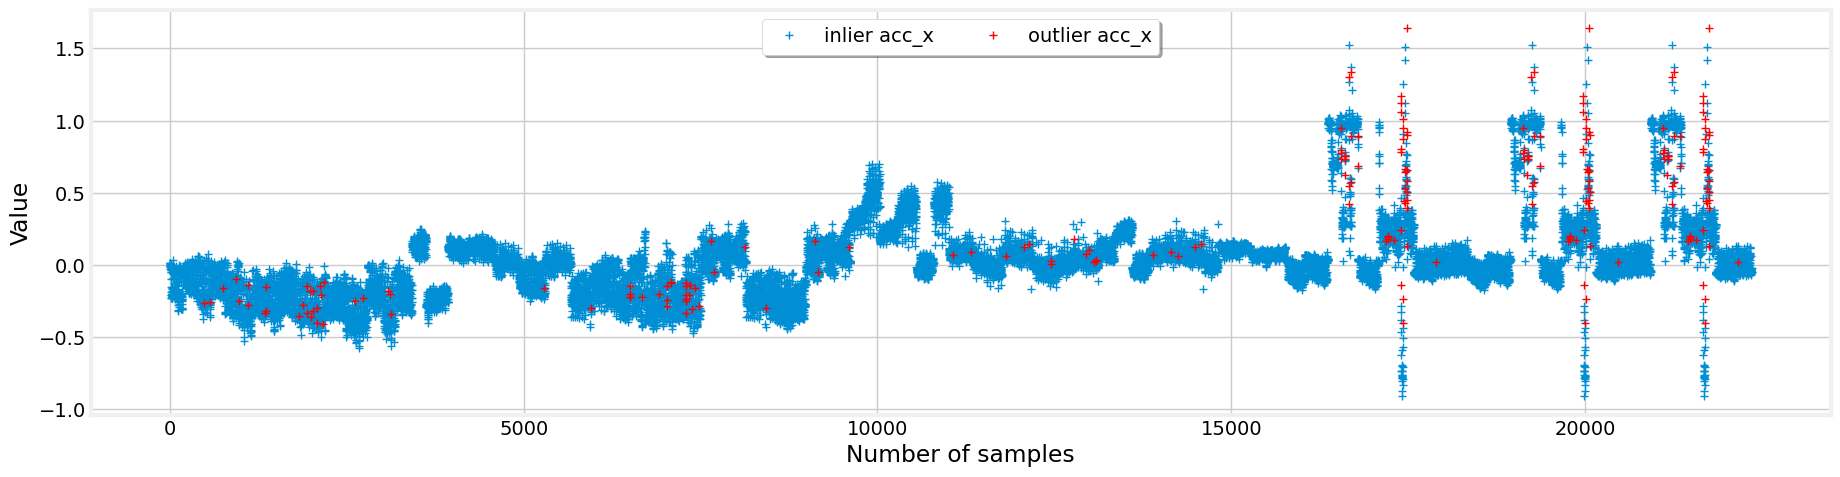

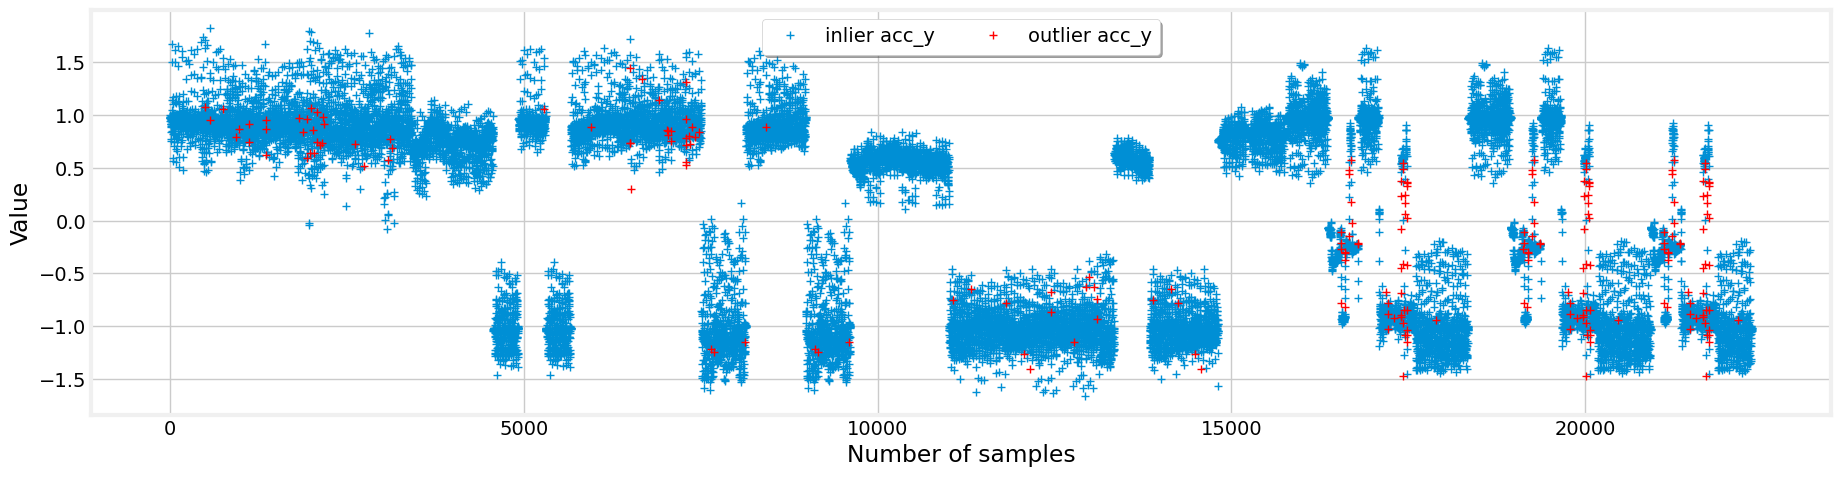

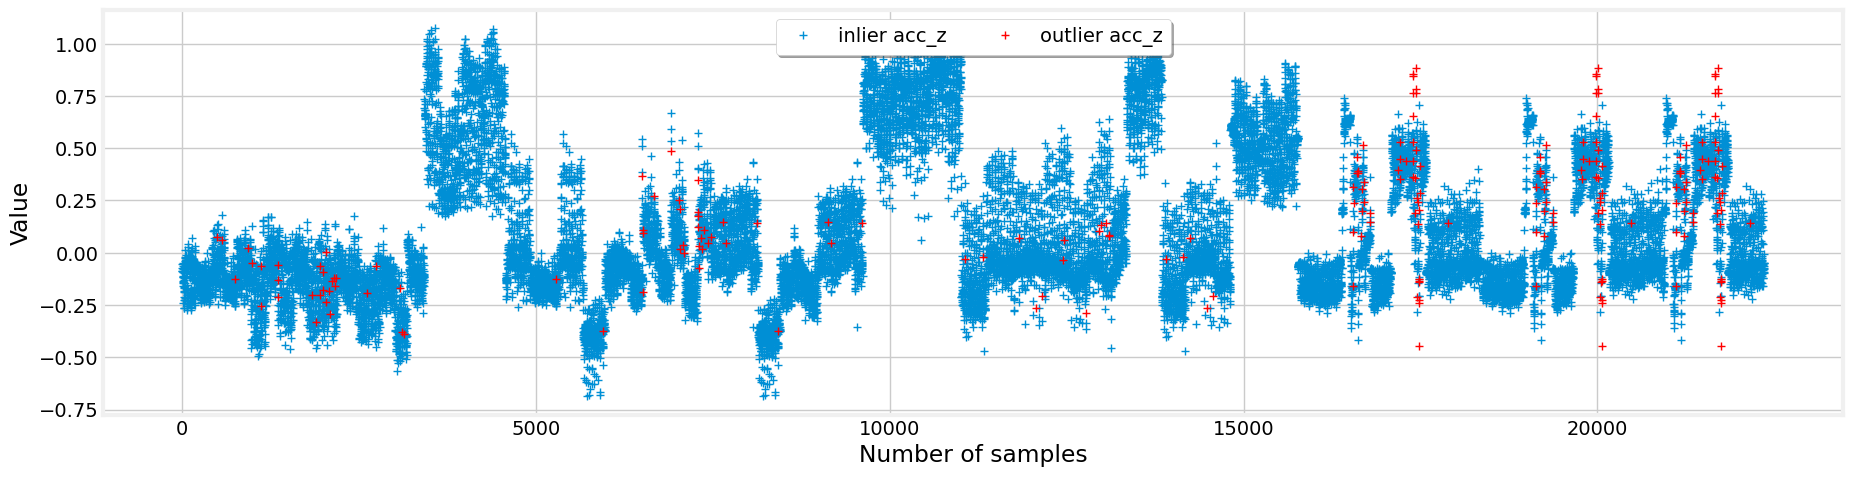

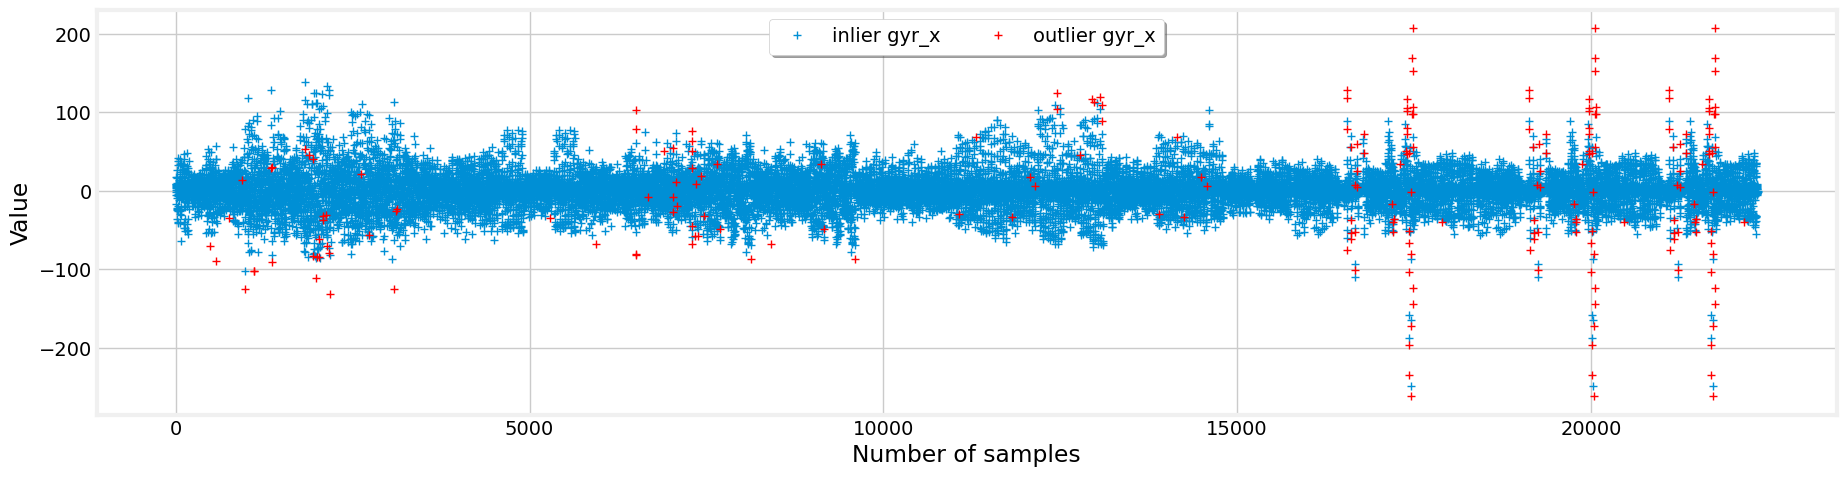

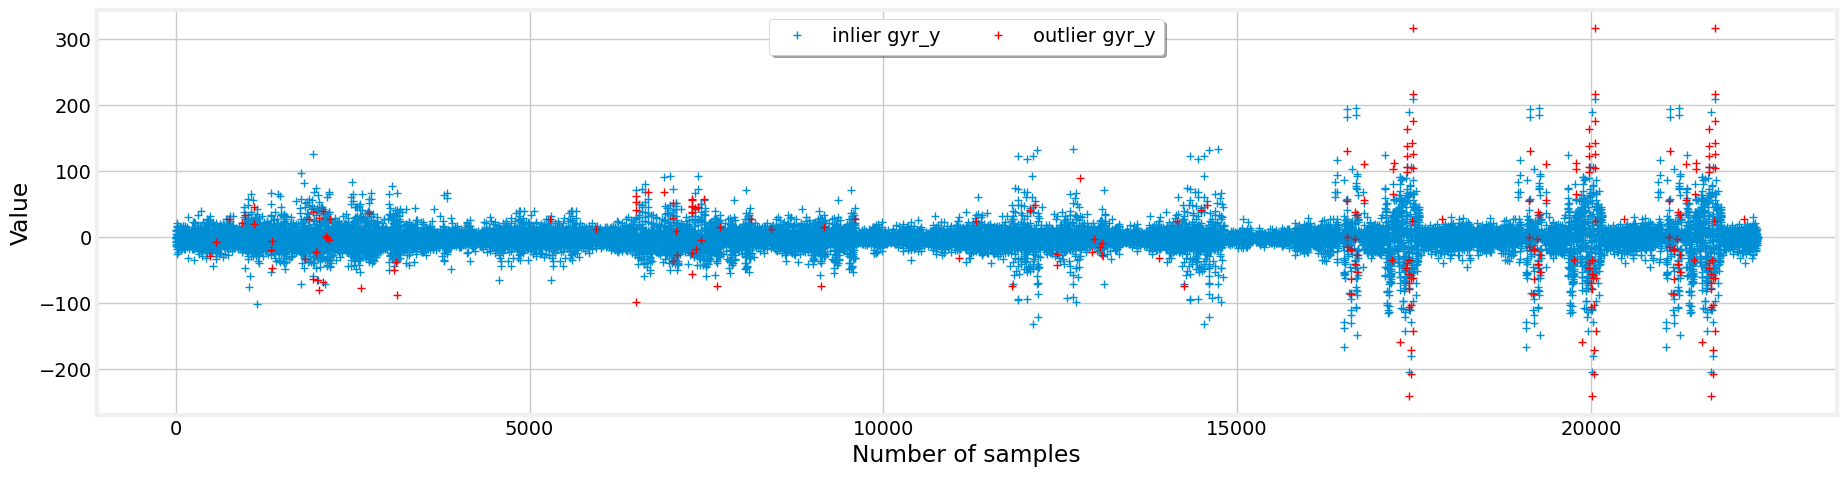

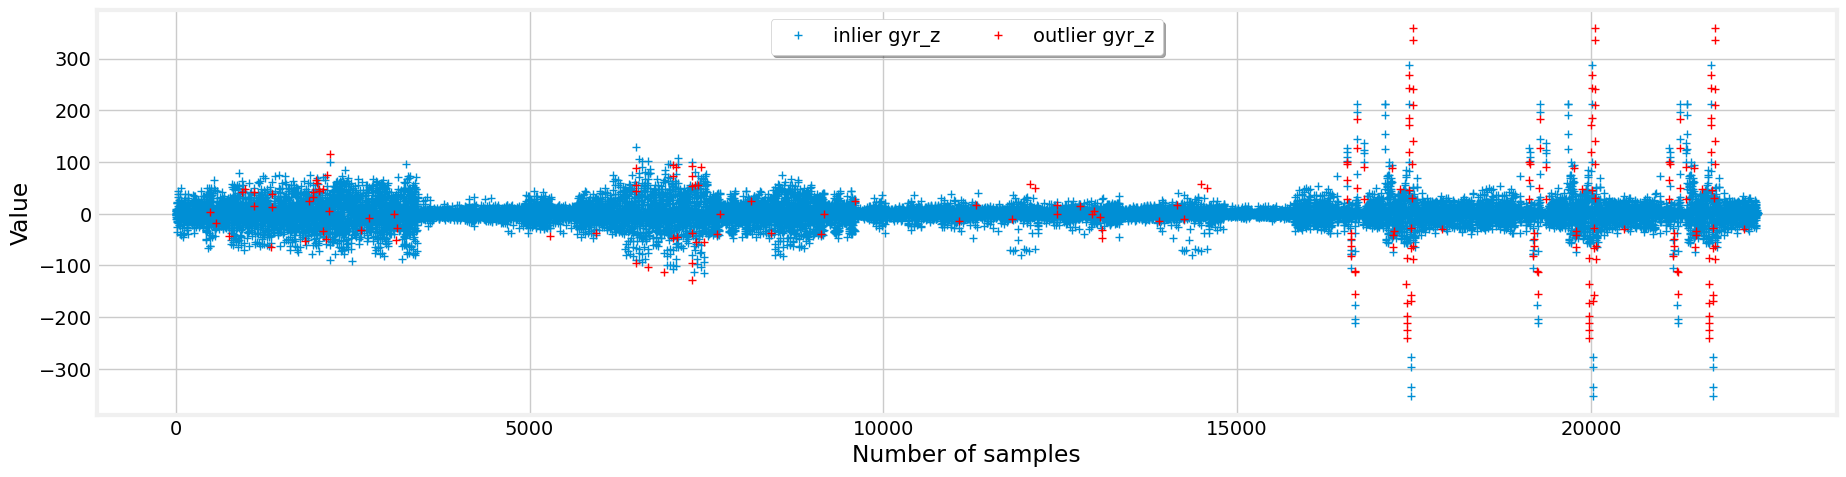

In [46]:
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)
print(X_scores)

for col in outlier_columns:
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True
    )

# 4. Xử lý ngoại lai

## 4.1. Loại bỏ ngoại lai

In [6]:
outliers_removed_df = df.copy()
for col in outlier_columns:
    for label in df["label"].unique():
        dataset = mark_outliers_chauvenet(df[df["label"] == label], col)

        # Replace values marked as outliers with NaN
        dataset.loc[dataset[col + "_outlier"], col] = np.nan

        # Update the column in the original dataframe
        outliers_removed_df.loc[(outliers_removed_df["label"] == label), col] = dataset[
            col
        ]

        n_outliers = len(dataset) - len(dataset[col].dropna())
        print(f"Removed {n_outliers} from {col} for {label}")

Removed 0 from acc_x for bench
Removed 0 from acc_x for ohp
Removed 0 from acc_x for squat
Removed 5 from acc_x for dead
Removed 0 from acc_x for row
Removed 0 from acc_x for rest
Removed 12 from acc_y for bench
Removed 10 from acc_y for ohp
Removed 0 from acc_y for squat
Removed 0 from acc_y for dead
Removed 2 from acc_y for row
Removed 0 from acc_y for rest
Removed 12 from acc_z for bench
Removed 10 from acc_z for ohp
Removed 0 from acc_z for squat
Removed 0 from acc_z for dead
Removed 0 from acc_z for row
Removed 0 from acc_z for rest
Removed 10 from gyr_x for bench
Removed 13 from gyr_x for ohp
Removed 3 from gyr_x for squat
Removed 10 from gyr_x for dead
Removed 0 from gyr_x for row
Removed 39 from gyr_x for rest
Removed 21 from gyr_y for bench
Removed 31 from gyr_y for ohp
Removed 18 from gyr_y for squat
Removed 53 from gyr_y for dead
Removed 14 from gyr_y for row
Removed 30 from gyr_y for rest
Removed 23 from gyr_z for bench
Removed 2 from gyr_z for ohp
Removed 30 from gyr_z for

## 4.2. Xử lý các giá trị thiếu

In [7]:
for col in outlier_columns:
    outliers_removed_df[col] = outliers_removed_df[col].interpolate()
    
outliers_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22356 entries, 2019-01-11 15:08:05.280000 to 2019-01-20 17:33:27.760000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        22356 non-null  float64
 1   acc_y        22356 non-null  float64
 2   acc_z        22356 non-null  float64
 3   gyr_x        22356 non-null  float64
 4   gyr_y        22356 non-null  float64
 5   gyr_z        22356 non-null  float64
 6   participant  22356 non-null  object 
 7   label        22356 non-null  object 
 8   category     22356 non-null  object 
 9   set          22356 non-null  int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 1.8+ MB


# 5. Xuất file dữ liệu

In [8]:
outliers_removed_df.to_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")